# Documentation
## Running
1. Running the notebook as is should produce the submission file required. There is no need to run the preprocessing steps if using saved models, which is the default. It suffices to run all cells below the [Ensembling](#Ensemble-training) section. Please be sure to run the [imports](#Imports) section first, though.

## Feature generation
1. Aggregate features are used (total sales per month aggregated over per shop, per category, per item)
2. Each aggregate feature is lagged at 1,2,3, and 12 months
3. The features are not pre-processed for the LightGBM model since it is robust to most transformations, but a `StandardScaler` is used to pre-process data for the neural network.
4. Text features are extracted using TF-IDF and then dimensionality reduced using parameters obtained from EDA (clustering) but not used in the final model since they did not seem to help.
5. The aggregate features for shops, categories, items form a kind of expanding scheme mean encoding.

## EDA
1. All EDA is done in the EDA section below.
2. Seasonality is examined, as well as general trends in sales on a per-shop and per-category basis, which are used to obtain similarity information between shops and categories.
3. Data leakages are investigated using the distributions of monthly sales, but nothing was found.

## Validation
1. The data is split into blocks, where each block contains data for a single month.
2. In order to ensure that the test and train sets are similar, each training block has additional item-shop pairs from the test block added to it, with 0 monthly sales where no data is available.
3. Hyperparameter tuning is done for the level 1 models using blocks 31, 32, and 33 for validation 
3. Meta-features are generated using blocks [13,30] for validation
4. Tuning and meta-feature generation are done on entirely separate blocks, so there is no data leakage between the two levels of models.
5. At each model, the MSE is optimized directly, which is equivalent to optimizing the RMSE.

## Ensembling details
1. A simple regularized linear model `ElasticNet` is used for ensembling, using the block-wise separation (scheme f. from the course).
2. A tree-based model (LightGBM) and a neural network model are used as base estimators.

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
import pickle
from tqdm import tqdm_notebook as tqdm
from math import log2, sqrt
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasRegressor
from lightgbm.sklearn import LGBMRegressor

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [15, 5]

LOAD_SAVED = True
TUNE_MODELS = False
ENSEMBLE_EPOCHS = 1
ENSEMBLE_N_TREES = 100
TUNE_N_EVALS = 5
LEVEL1WINDOWS = range(31, 34)
LEVEL2WINDOWS = range(13, 31)

Using TensorFlow backend.


## Loading data

In [2]:
sales_train = pd.read_csv('./data/sales_train.csv')
items = pd.read_csv('./data/items.csv')
item_categories = pd.read_csv(
    './data/item_categories.csv')
shops = pd.read_csv('./data/shops.csv')
test_df = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv(
    './data/sample_submission.csv')

# EDA + Pre-processing

In [3]:
plt.rc('figure', figsize=(24, 5))
sales_train.date = pd.to_datetime(sales_train.date, format="%d.%m.%Y")
sales_train = sales_train.assign(day=sales_train.date.dt.day)
sales_train = sales_train.assign(month=sales_train.date.dt.month)
sales_train = sales_train.assign(year=sales_train.date.dt.year)
sales_train = sales_train.assign(sales=sales_train.item_cnt_day *
                                 sales_train.item_price)
sales_train = sales_train.drop(['date'], axis=1)
cat_ids = items.iloc[sales_train.item_id].item_category_id.values
sales_train = sales_train.assign(cat_id=cat_ids)

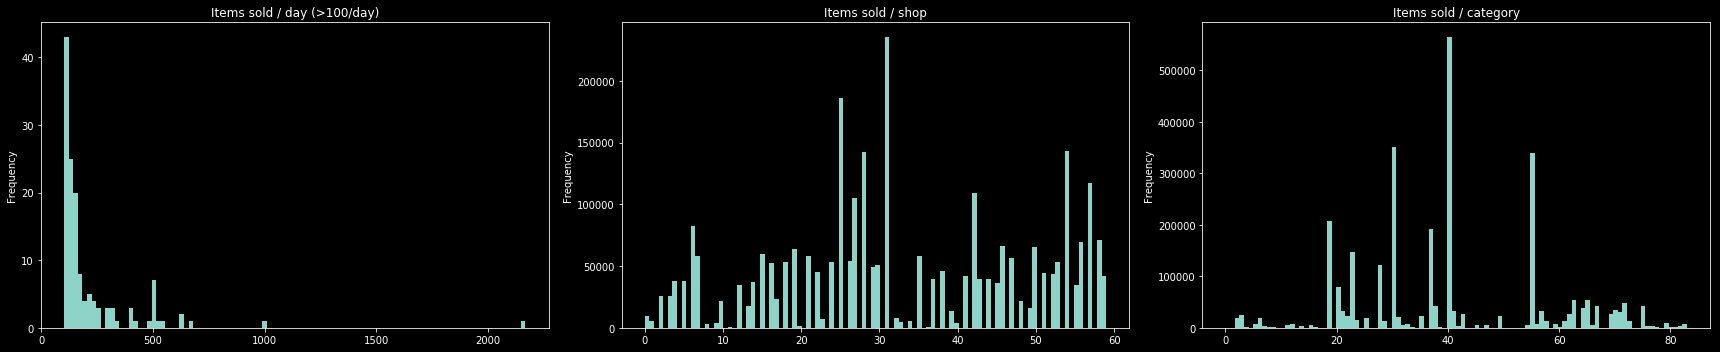

In [4]:
sales_day = sales_train.item_cnt_day
sales_day_longtail = sales_day[(sales_day > 100)]
sales_day_longtail.plot(
    'hist',
    bins=100,
    ax=plt.subplot(1, 3, 1),
    title='Items sold / day (>100/day)')
sales_train.shop_id.plot(
    'hist', bins=100, ax=plt.subplot(1, 3, 2), title='Items sold / shop')
items.iloc[sales_train.item_id].item_category_id.plot(
    'hist', bins=100, ax=plt.subplot(1, 3, 3), title='Items sold / category')
plt.tight_layout()
plt.show()

del sales_day

1. The per-category sales and the per shop sales seem to be fairly well-distributed.
2. There is a long tail of items sold/day that extends into the mid-hundreds, although it seems reasonably to call anything more than 500 an outlier for our purposes.
3. There is clearly an outlier in the `item_cnt_day` column, somewhere on the order of 2,000 sales a day, which is highly improbable.

## Lagged features
1. Look at seasonality in sales. We want sales counts for every month given the `shop_id` and the `item_id`, which together make up ID. This also gives us the structure for our output dataframe. 
2. With the data that we have, its clear that monthly sales are highly correlated with sales of that month from the previous year. Therefore, features lagged by a year and also by 2 years should work well.  
4. Look at how the distribution of sales/category changes over time (older models of consoles, for instance, should lose sales in favor of newer models).
3. Investigate sales in May and April 2015, what causes that uptick?

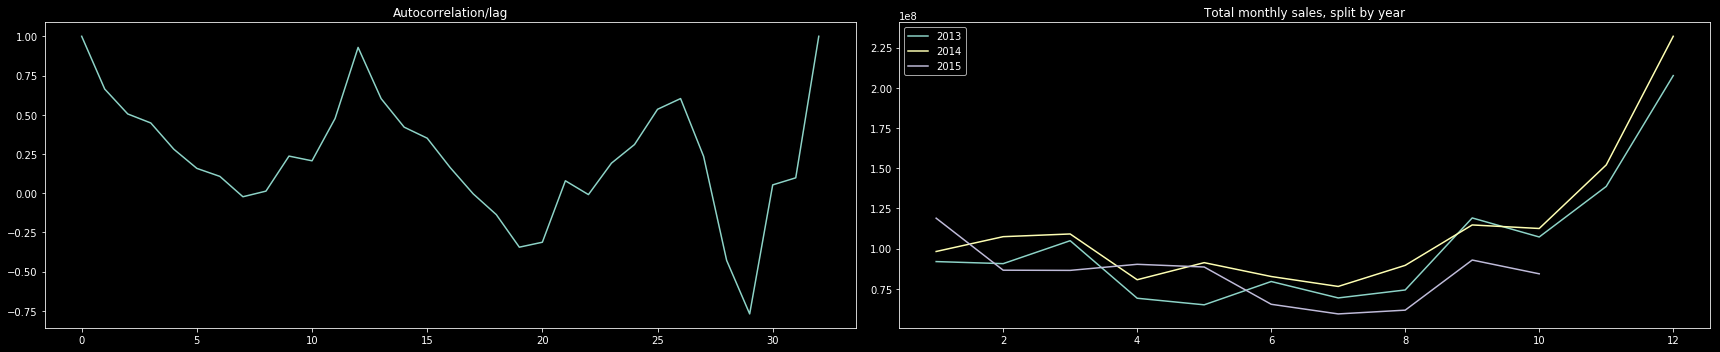

In [5]:
monthly_sales = sales_train.groupby('date_block_num').item_cnt_day.sum()
autocorrelations = [
    monthly_sales.autocorr(i) for i in range(len(monthly_sales) - 1)
]

plt.subplot(1, 2, 1)
plt.plot(autocorrelations)
plt.title("Autocorrelation/lag")
plt.subplot(1, 2, 2)
for year in sales_train.year.unique():
    monthly_sales = sales_train.loc[sales_train.year == year, :].groupby(
        'month').sales.sum()
    plt.plot(monthly_sales)
plt.legend(sales_train.year.unique())
plt.title("Total monthly sales, split by year")
plt.tight_layout()
plt.show()

del monthly_sales

## Correlation between shops, categories

In [6]:
cat_monthly_sales = sales_train.pivot_table(
    index='date_block_num',
    values='item_cnt_day',
    columns='cat_id',
    fill_value=0,
    aggfunc=np.sum)
shop_monthly_sales = sales_train.pivot_table(
    index='date_block_num',
    values='item_cnt_day',
    columns='shop_id',
    fill_value=0,
    aggfunc=np.sum)
item_monthly_sales = sales_train.pivot_table(
    index='date_block_num',
    values='item_cnt_day',
    columns='item_id',
    fill_value=0,
    aggfunc=np.sum)

/home/manas/.virtualenvs/dl-spec-pvGT5B3I/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  # This is added back by InteractiveShellApp.init_path()


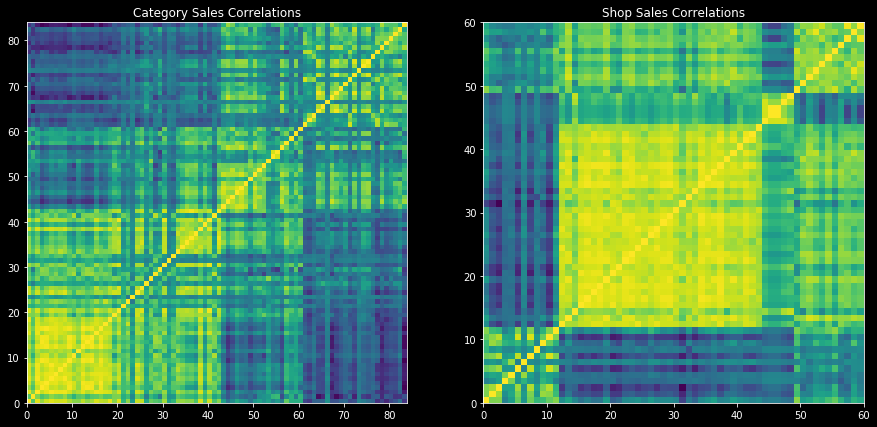

In [7]:
import scipy
import scipy.cluster.hierarchy as hclust


def plot_corr(df):
    X = df.corr().values
    distance = hclust.distance.pdist(X)
    linkage = hclust.linkage(distance, method='complete')
    indices = hclust.fcluster(linkage, 0.5 * distance.max(), 'distance')
    cols = [df.columns.tolist()[i] for i in list((np.argsort(indices)))]
    df = df.reindex_axis(cols, axis=1)
    plt.pcolor(df.corr())
    return df


plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
cat_monthly_sales = plot_corr(cat_monthly_sales)
plt.title("Category Sales Correlations")
plt.subplot(1, 2, 2)
shop_monthly_sales = plot_corr(shop_monthly_sales)
plt.title("Shop Sales Correlations")
plt.show()

## Sales counts by category

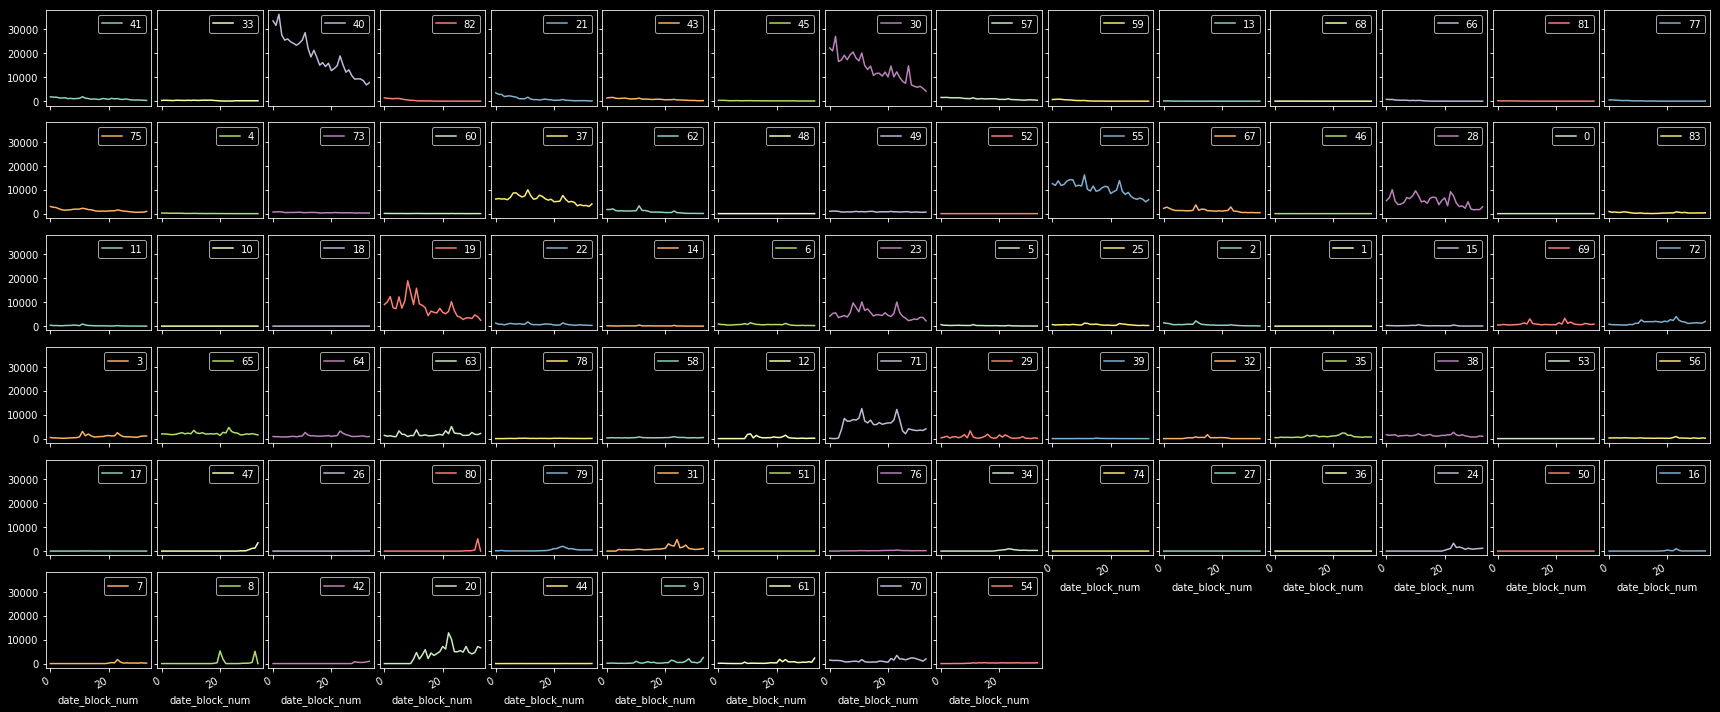

In [8]:
n = items.item_category_id.nunique()
m = 15
cat_monthly_sales.plot(
    legend=True,
    subplots=True,
    sharex=True,
    sharey=True,
    layout=(n // m + 1, m),
    figsize=(24, 10))
plt.tight_layout(h_pad=-2.0, w_pad=-0.5)
plt.show()

## Sales counts by shop

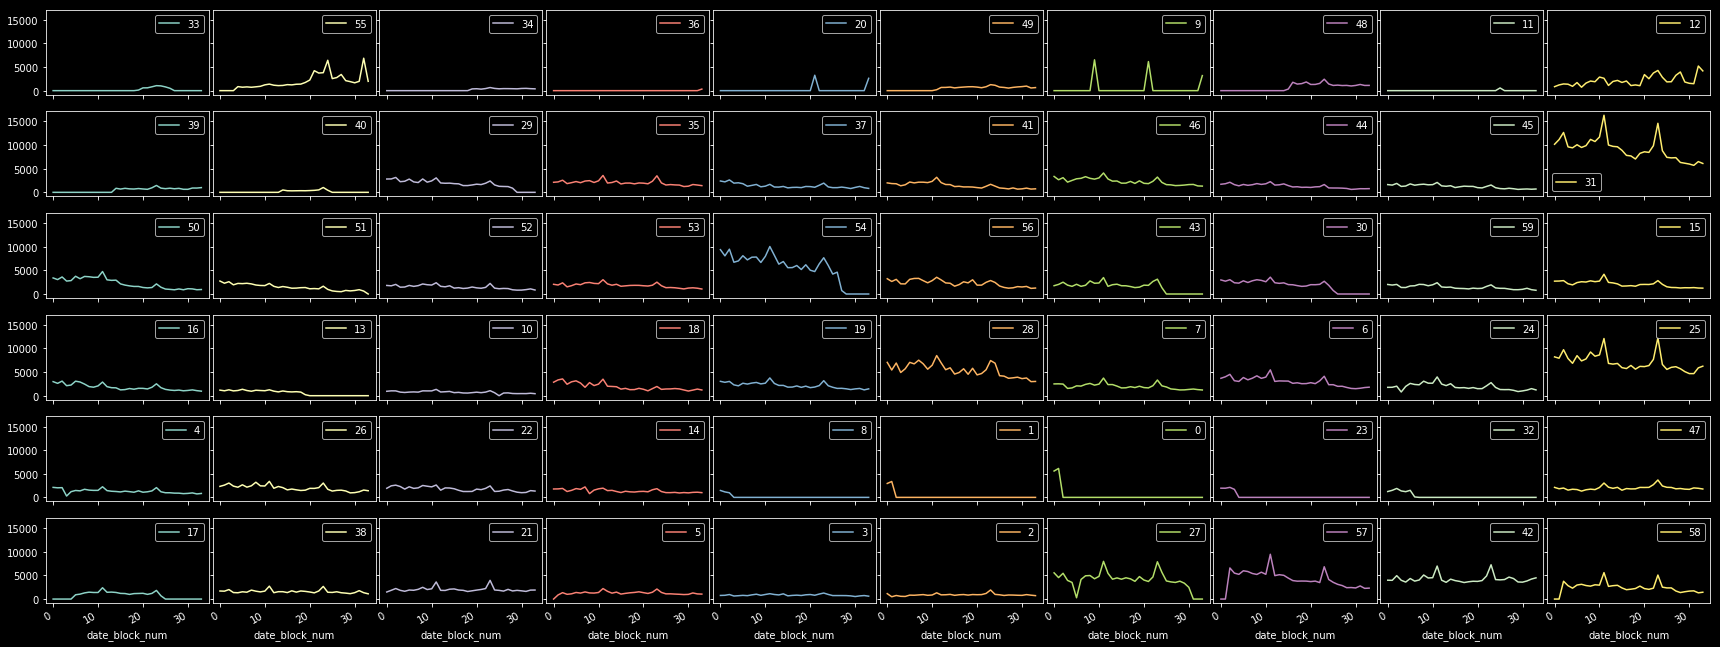

In [9]:
n = sales_train.shop_id.nunique()
m = 10
shop_monthly_sales.plot(
    legend=True,
    subplots=True,
    sharex=True,
    sharey=True,
    layout=(n // m + 1, m),
    figsize=(24, 10))
plt.tight_layout(h_pad=-2.0, w_pad=-0.5)
plt.show()

In [10]:
# Cleanup
del shop_monthly_sales
del cat_monthly_sales
del item_monthly_sales
gc.collect()

169528

## Extracting text features from shop name, category name
The reduced dimensions are chosen by looking at the rough number of clusters visible in the correlation matrix obtained from monthly sales counts. The target dimension for `item_name_vec` is more or less arbitrary, though.

In [11]:
shop_vec = TfidfVectorizer().fit_transform(shops.shop_name.values)
shop_vec = TruncatedSVD(random_state=0, n_components=4).fit_transform(shop_vec)

item_name_vec = TfidfVectorizer().fit_transform(items.item_name.values)
item_name_vec = TruncatedSVD(
    random_state=0, n_components=64).fit_transform(item_name_vec)

cat_name_vec = TfidfVectorizer().fit_transform(
    item_categories.item_category_name.values)
cat_name_vec = TruncatedSVD(
    random_state=0, n_components=4).fit_transform(cat_name_vec)

# Feature engineering
Feature ideas:
1. Mean sales of the corresponding category (`cat_monthly_sales`) - basically a form of mean encoding
2. Mean sales of the corresponding shop (`shop_monthly_sales`) - again, a form of mean encoding
3. Mean sales of the corresponding item (`item_monthly_sales`) - again, a form of mean encoding
4. Lagged sales features (by shop, by category, by item, extract from the previous three); encodes history as well as seasonality (12 and 24 months)
5. Text features: `shop_name`,`item_category_name`; need to use embeddings, etc. Use similarity between names as a feature?
6. Could use embedding similarity between category names; mean sales of items in "nearby" categories as lagged feature


## Aggregate to get monthly numbers

In [12]:
groups = ['shop', 'item', 'cat']
index_cols = [g + '_id' for g in groups] + ['date_block_num']

all_data = sales_train
all_data = (all_data.groupby(index_cols, as_index=False)
            .item_cnt_day.sum().rename(columns={'item_cnt_day': 'target'}))
# Clip monthly sales to get rid of outliers
all_data.loc[all_data.target < 0, 'target'] = 0
all_data.loc[all_data.target > 20, 'target'] = 20

## Backfill test shop + item pairs so that train/validation data looks like test data

(8505965, 5)


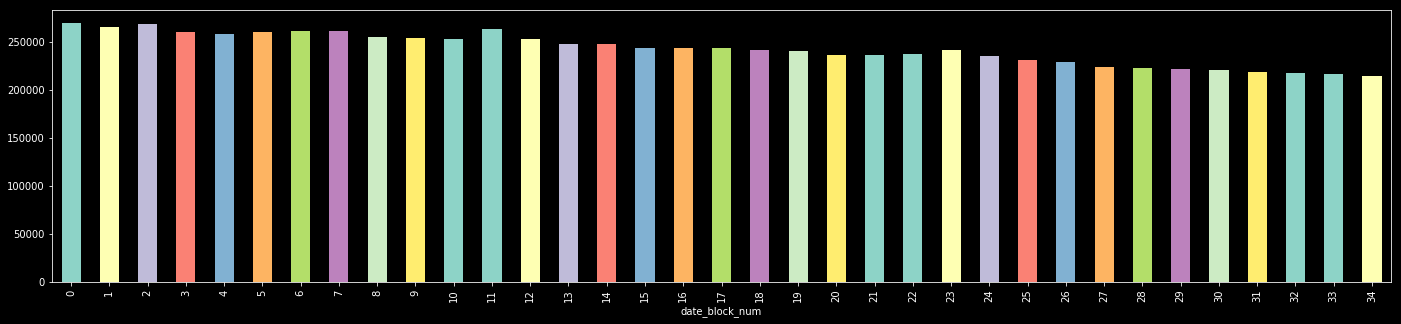

In [13]:
# Backfill these with 0 counts so that the models learn a balanced
# representation; training data that looks like the test data
for block in all_data.date_block_num.unique():
    test_pairs = test_df.groupby(['item_id', 'shop_id']).count().index
    train_pairs = (all_data.loc[all_data.date_block_num == block]
                   .groupby(['item_id', 'shop_id']).count().index)
    test_not_in_train = test_pairs.difference(train_pairs)
    test_not_in_train = (test_df.groupby(['item_id', 'shop_id']).count()
                         .loc[test_not_in_train].reset_index().assign(target=0)
                         .assign(cat_id=lambda df: (items.iloc[df.item_id]
                                                    .item_category_id.values))
                         .drop('ID', 1))
    all_data = all_data.append(
        test_not_in_train.assign(date_block_num=block), sort=True)
    
# Add a dummy date_block_num = 34 set to use as X_test
all_data = all_data.append((test_df.rename(columns={
    "ID": "target"
}).assign(target=0).assign(cat_id=lambda df: (items.iloc[df.item_id]
                                              .item_category_id.values))
                            .assign(date_block_num=34)), sort=True)

print(all_data.shape)
all_data.groupby('date_block_num').target.count().plot('bar')
plt.show()

## Add grouped features (mean encoding + using feature similarity)


In [14]:
def downcast_dtypes(df):
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype == "int64"]
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int32)
    return df


# Add groups; mean monthly sales per group
for group in groups:
    gid = group + '_id'
    tag = 'target_' + group
    grouped = (all_data.groupby([gid, 'date_block_num'], as_index=False)
               .target.sum().rename(columns={'target': tag}))
    all_data = pd.merge(
        all_data, grouped, how='left', on=[gid, 'date_block_num']).fillna(0)
    del grouped

all_data = downcast_dtypes(all_data)
gc.collect()
all_data.head()

,cat_id,date_block_num,item_id,shop_id,target,target_shop,target_item,target_cat
0,40,1,30,0,20.0,5820.0,573.0,29292.0
1,37,1,31,0,11.0,5820.0,515.0,6188.0
2,40,0,32,0,6.0,5411.0,242.0,31656.0
3,40,1,32,0,10.0,5820.0,206.0,29292.0
4,37,0,33,0,3.0,5411.0,61.0,5982.0


## Add lagged features

In [15]:
lags = [1, 2, 3,12]
index_cols = [c for c in index_cols if c != 'cat_id']
cols_to_rename = ['target_' + g for g in groups] + ['target']
for month_shift in tqdm(lags):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)
    all_data = all_data.merge(
        train_shift, on=index_cols, how='left', copy=False,
        validate='1:1').fillna(0)
    del train_shift

all_data = all_data[all_data['date_block_num'] >= 12]
gc.collect()
all_data.head()

,cat_id,date_block_num,item_id,shop_id,target,target_shop,target_item,target_cat,target_shop_lag_1,target_item_lag_1,...,target_cat_lag_2,target_lag_2,target_shop_lag_3,target_item_lag_3,target_cat_lag_3,target_lag_3,target_shop_lag_12,target_item_lag_12,target_cat_lag_12,target_lag_12
8104,19,17,27,2,1.0,893.0,3.0,5577.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8107,40,15,30,2,1.0,759.0,21.0,17333.0,928.0,31.0,...,18061.0,0.0,863.0,58.0,21552.0,0.0,585.0,130.0,25779.0,0.0
8108,40,16,30,2,1.0,841.0,16.0,14765.0,759.0,21.0,...,20143.0,0.0,868.0,24.0,18061.0,0.0,553.0,50.0,24166.0,0.0
8112,37,16,31,2,1.0,841.0,22.0,7182.0,759.0,21.0,...,6319.0,0.0,868.0,14.0,6026.0,0.0,553.0,31.0,5744.0,0.0
8113,37,33,31,2,1.0,717.0,18.0,3967.0,803.0,9.0,...,3370.0,0.0,763.0,6.0,3291.0,0.0,880.0,8.0,5036.0,0.0


# Ensembling
1. Pick models to use, pre-process features for each model
    1. Use lightgb and a neural net 
2. Use `hyperopt` to tune hyperparameters
3. Ensemble using a shallow neural net 

In [16]:
dates = all_data.date_block_num
drop_cols = ['target', 'target_shop', 'target_item', 'target_cat']
drop_cols += index_cols

X_train = all_data.loc[dates < 34].drop(drop_cols, 1)
y_train = all_data.loc[dates < 34].target
X_test = all_data.loc[dates == 34].drop(drop_cols, 1)
dates = all_data.loc[dates < 34].date_block_num

def date_splits(dates, level=1):
    if (level == 1):
        windows = LEVEL1WINDOWS
    else:
        windows = LEVEL2WINDOWS
    for d in windows:
        if (level == 1):
            train_idx = np.argwhere(dates == d - 1)[:, 0]
        else:
            train_idx = np.argwhere(dates < d)[:, 0]
        test_idx = np.argwhere(dates == d)[:, 0]
        yield train_idx, test_idx

In [17]:
X_train.head()

,cat_id,target_shop_lag_1,target_item_lag_1,target_cat_lag_1,target_lag_1,target_shop_lag_2,target_item_lag_2,target_cat_lag_2,target_lag_2,target_shop_lag_3,target_item_lag_3,target_cat_lag_3,target_lag_3,target_shop_lag_12,target_item_lag_12,target_cat_lag_12,target_lag_12
8104,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8107,40,928.0,31.0,20143.0,0.0,868.0,24.0,18061.0,0.0,863.0,58.0,21552.0,0.0,585.0,130.0,25779.0,0.0
8108,40,759.0,21.0,17333.0,1.0,928.0,31.0,20143.0,0.0,868.0,24.0,18061.0,0.0,553.0,50.0,24166.0,0.0
8112,37,759.0,21.0,7706.0,0.0,928.0,11.0,6319.0,0.0,868.0,14.0,6026.0,0.0,553.0,31.0,5744.0,0.0
8113,37,803.0,9.0,2961.0,0.0,942.0,53.0,3370.0,0.0,763.0,6.0,3291.0,0.0,880.0,8.0,5036.0,0.0


## Baseline previous month sanity check

In [18]:
for train, test in date_splits(all_data.date_block_num):
    score = mean_squared_error(all_data.iloc[test].target,
                               all_data.iloc[test].target_lag_1)
    print("RMSE {:.3f}".format(sqrt(score)))

RMSE 0.910
RMSE 1.060
RMSE 1.188


## Baseline Linear Regression

In [19]:
clf = ElasticNet(l1_ratio=0.01)
score = cross_val_score(
    clf,
    X_train,
    y_train,
    scoring='neg_mean_squared_error',
    cv=date_splits(dates)).mean()
print("RMSE {:.3f}".format(sqrt(-score)))

RMSE 0.958


## LightGBM tuning

In [20]:
np.random.seed(1337) # for reproducibility

def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'min_data_in_leaf': int(params['min_data_in_leaf']),
        'feature_fraction': float(params['feature_fraction']),
        'bagging_fraction': float(params['bagging_fraction']),
        'learning_rate': float(params['learning_rate']),
    }

    clf = LGBMRegressor(n_estimators=100, **params)

    score = cross_val_score(
        clf,
        X_train,
        y_train,
        scoring='neg_mean_squared_error',
        cv=date_splits(dates)).mean()
    print("RMSE {:.3f} params {}".format(sqrt(-score), params))
    return sqrt(-score)


space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 10, 100, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.75, 1.0),
    'learning_rate': hp.loguniform('learning_rate', -6.9, -2.3)
}

if (TUNE_MODELS):
    best_lgb = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=5*TUNE_N_EVALS)
    print(best_lgb)
else:
    # 12...n
    best_lgb = {'bagging_fraction': 0.8609731681267454, 'feature_fraction': 0.9750002226449819, 'learning_rate': 0.07658231928380872, 
                'min_data_in_leaf': 21.0, 'min_sum_hessian_in_leaf': 1.6464529442795883, 'num_leaves': 92.0}
    # 12...n, n->n+1
    best_lgb = {'bagging_fraction': 0.9356312908694342, 'feature_fraction': 0.7734773201004939, 'learning_rate': 0.061477868079466376, 
                'min_data_in_leaf': 88.0, 'num_leaves': 12.0}
    # best from submission run
    best_lgb = {'bagging_fraction': 0.7641587141706275, 'feature_fraction': 0.9896923305891798, 'learning_rate': 0.0561368960915148, 
                'min_data_in_leaf': 88.0, 'num_leaves': 32.0}


## NN tuning

In [21]:

np.random.seed(1337) # for reproducibility

def construct_nn(input_dim, n_layers, n_hidden, regularize):
    
    n_layers = min(n_layers, int(log2(n_hidden)))
    layers = [
        Dense(
            n_hidden,
            input_dim=input_dim,
            activation='relu',
            kernel_regularizer=l2(regularize)),
    ]
    for i in range(n_layers):
        layers.append(
            Dense(
                n_hidden // 2**i,
                activation='relu',
                kernel_regularizer=l2(regularize)))
    layers.append(Dense(1, activation='relu'))
    model = Sequential(layers)
    model.compile(optimizer='adam', loss='mse')
    return model

def objective(params):
    params = {
        'n_layers': int(params['n_layers']),
        'n_hidden': int(params['n_hidden']),
        'regularize': float(params['regularize']),
        'input_dim': X_train.shape[1],
        'epochs': 1,
        'batch_size': 64
    }

    clf = make_pipeline(StandardScaler(), KerasRegressor(construct_nn, **params))
    score = cross_val_score(
        clf,
        X_train,
        y_train,
        scoring='neg_mean_squared_error',
        cv=date_splits(dates)).mean()

    print("RMSE {:.3f} params {}".format(sqrt(-score), params))
    return sqrt(-score)


space = {
    'n_layers': hp.quniform('n_layers', 1, 5, 1),
    'n_hidden': hp.quniform('n_hidden', 32, 128, 2),
    'regularize': hp.loguniform('regularize', -6.9, -0.1)
}

if TUNE_MODELS:
    best_nn = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=TUNE_N_EVALS)
#     best_nn = {'n_hidden': 64.0, 'n_layers': 5.0, 'regularize': 0.02716892244239013}
    print(best_nn)
else:
    # 12...n->n+1
    best_nn = {'n_hidden': 78.0, 'n_layers': 3.0, 'regularize': 0.004021306374817419}
    # 12...n, n->n+1
    best_nn = {'n_hidden': 64.0, 'n_layers': 5.0, 'regularize': 0.02716892244239013}
    # best from submission run
    best_nn = {'n_hidden': 120.0, 'n_layers': 2.0, 'regularize': 0.0058298763081377466}

## Ensemble training

### Create train meta-features

In [22]:
best_lgb['num_leaves'] = int(best_lgb['num_leaves'])
best_lgb['min_data_in_leaf'] = int(best_lgb['min_data_in_leaf'])
best_nn['n_hidden'] = int(best_nn['n_hidden'])
best_nn['n_layers'] = int(best_nn['n_layers'])
best_nn['batch_size'] = 128

nn = make_pipeline(StandardScaler(), KerasRegressor(
    construct_nn,
    input_dim=X_train.shape[1],
    epochs=ENSEMBLE_EPOCHS,
    **best_nn))
# nn = ElasticNet(l1_ratio=0.01)

lgbm = LGBMRegressor(n_estimators=ENSEMBLE_N_TREES, **best_lgb)

def get_metafeatures(nn, lgbm, X_train, y_train):
    X_train_level2 = np.zeros([X_train.shape[0], 2])
    for train, test in tqdm(date_splits(dates, level=2),
                            total=len(LEVEL2WINDOWS)):
        nn.fit(X_train.iloc[train], y_train.iloc[train])
        nn_pred = nn.predict(X_train.iloc[test])
        X_train_level2[test, 1] = nn_pred
        print("nn val RMSE: ", mean_squared_error(nn_pred, y_train.iloc[test]))

        lgbm.fit(X_train.iloc[train], y_train.iloc[train])
        lgb_pred = lgbm.predict(X_train.iloc[test])
        X_train_level2[test, 0] = lgb_pred
        print("lgbm val RMSE: ", mean_squared_error(
            lgb_pred, y_train.iloc[test]))

    X_train_level2 = X_train_level2[[d in LEVEL2WINDOWS for d in dates], :]
    y_train_level2 = y_train.loc[[d in LEVEL2WINDOWS for d in dates]]
    return nn, lgbm, X_train_level2, y_train_level2

if(LOAD_SAVED):
    X_train_level2 = pickle.load(open("./metafeatures/X_train_level2.pkl", 'rb'))
    y_train_level2 = pickle.load(open("./metafeatures/y_train_level2.pkl", 'rb'))
else:
    nn, lgbm, X_train_level2, y_train_level2 = get_metafeatures(nn, lgbm, X_train, y_train)
    pickle.dump(X_train_level2, open('./metafeatures/X_train_level2.pkl', 'wb'))
    pickle.dump(y_train_level2, open('./metafeatures/y_train_level2.pkl', 'wb'))

### Check Independence

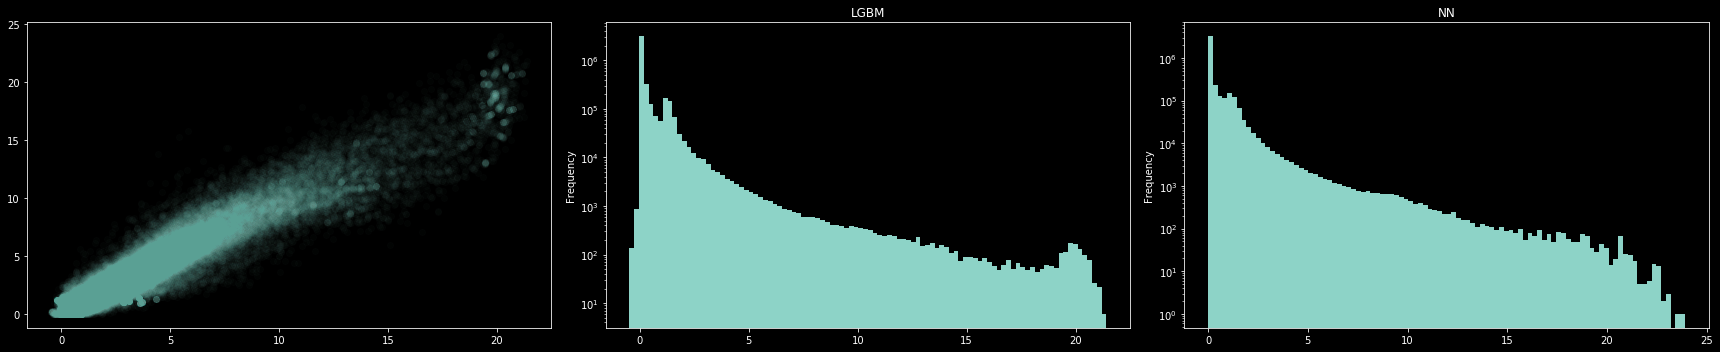

In [24]:
plt.subplot(1, 3, 1)
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1], alpha=0.02)
pd.Series((X_train_level2[:, 0])).plot(logy=True, title='LGBM',
    kind='hist', bins=100, ax=plt.subplot(1, 3, 2))
pd.Series((X_train_level2[:, 1])).plot(logy=True, title='NN',
    kind='hist', bins=100, ax=plt.subplot(1, 3, 3))
plt.tight_layout()
plt.show()

### Train the meta model

In [25]:
def get_meta_model():
    params = {
        'n_layers': 1,
        'n_hidden': 8,
        'regularize': 0.05,
        'input_dim': 2,
        'epochs': 1,
        'batch_size': 32,
    }

    shallow = KerasRegressor(construct_nn, **params)
    ensemble_scaler = StandardScaler()
    model = make_pipeline(ensemble_scaler, shallow)
    return model

def get_meta_model():
    model = ElasticNet(0.01)
    return model

meta_model = get_meta_model()
meta_model.fit(X_train_level2,y_train_level2)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

### Make submission

In [58]:
if LOAD_SAVED:
    lgbm = pickle.load(open("./metafeatures/lgbm.pkl", 'rb'))
    nn = pickle.load(open("./metafeatures/pipeline.pkl", 'rb'))
    nn.named_steps['kerasregressor'].model = load_model('./metafeatures/nn.pkl')
else:
    lgbm.fit(X_train, y_train)
    nn.fit(X_train, y_train)
    pickle.dump(lgbm, open('./metafeatures/lgbm.pkl', 'wb'))
    nn.steps[1][1].model.save('./metafeatures/nn.pkl')
    nn.named_steps['kerasregressor'].model = None
    pickle.dump(nn, open('./metafeatures/pipeline.pkl', 'wb'))

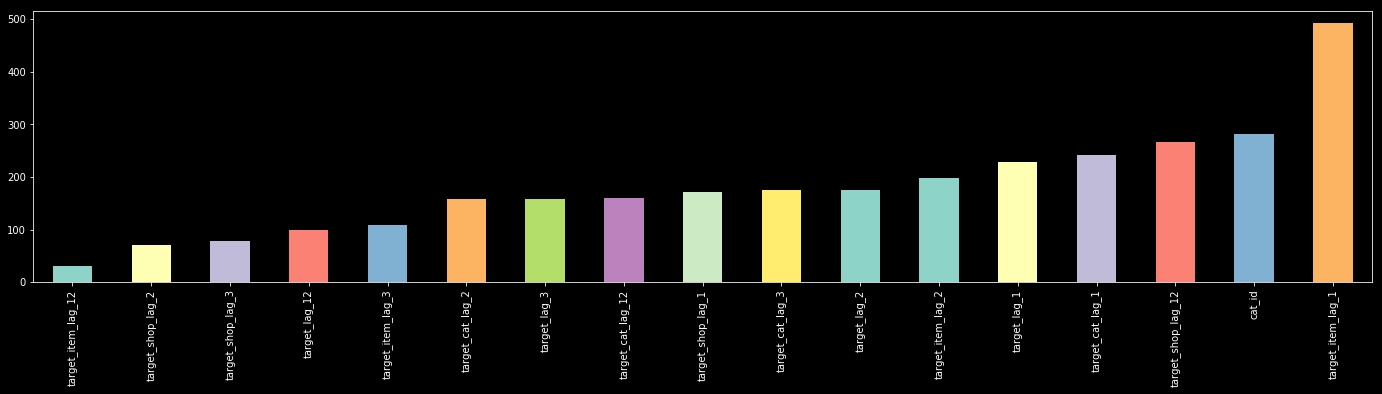

In [35]:
fimps, cols = zip(*sorted(zip(lgbm.feature_importances_, X_train.columns)))
pd.Series(fimps, cols).plot(kind='bar')

In [59]:
lgb_pred = lgbm.predict(X_test)
nn_pred = nn.predict(X_test)
X_test_level2 = np.vstack([lgb_pred, nn_pred]).T
predictions = all_data.loc[all_data.date_block_num == 34].assign(
#     target=lgb_pred)
#     target=nn_pred)
    target=meta_model.predict(X_test_level2))

submission = test_df.merge(
    predictions, how='left', on=['shop_id', 'item_id']).target.fillna(0)
submission = pd.DataFrame(submission)
submission.columns = ['item_cnt_month']
submission.index.rename('ID', inplace=True)
submission[submission < 0] = 0
submission[submission > 20] = 20
submission.to_csv('/tmp/sample_submission.csv', header=True)

### Sanity checks

In [ ]:
print("Ensemble RMSE: ", mean_squared_error(predictions.target_lag_1, predictions.target))
print("LGB RMSE: ", mean_squared_error(predictions.target_lag_1, X_test_level2[:,0]))
print("NN RMSE: ", mean_squared_error(predictions.target_lag_1, X_test_level2[:,1]))

In [ ]:
plt.subplot(1, 3, 1)
plt.scatter(X_test_level2[:, 0], X_test_level2[:, 1], alpha=0.2)
pd.Series(np.rint(lgb_pred)).plot('hist', bins=100, ax=plt.subplot(1, 3, 2), logy=True, title='LGBM')
pd.Series(np.rint(nn_pred)).plot('hist', bins=100, ax=plt.subplot(1, 3, 3), logy=True, title='NN')
plt.tight_layout()
plt.show()